In [4]:
from ultralytics import YOLO
from collections import Counter
import os
import cv2
import matplotlib.pyplot as plt

## Data Processing

In [38]:
def load_class_names(label_folder):

    classes_file = os.path.join(label_folder, "classes.txt")
    if not os.path.exists(classes_file):
        print(f"{classes_file} file not exists!")
        return {}

    with open(classes_file, "r", encoding="utf-8") as f:
        class_names = [line.strip() for line in f.readlines()]
    
    return {i: class_names[i] for i in range(len(class_names))}



def count_labels(label_folder):

    category_count = Counter()

    for label_file in os.listdir(label_folder):
        if label_file.endswith(".txt") and label_file != "classes.txt":
            with open(os.path.join(label_folder, label_file), "r", encoding="utf-8") as f:
                for line in f:
                    class_id = int(line.split()[0]) 
                    category_count[class_id] += 1 

    return category_count

datasets = ["train", "test", "val"]
base_path = "final_datasets/label"


for dataset in datasets:
    label_folder = os.path.join(base_path, dataset)
    class_map = load_class_names(label_folder)
    counts = count_labels(label_folder)

    print(f"\n {dataset.upper()} dataset:")
    
    for class_id in sorted(class_map.keys()):
        class_name = class_map.get(class_id, f"class {class_id}")
        count = counts.get(class_id, 0)
        print(f"{class_name} (class {class_id}): {count}")



 TRAIN dataset:
Large crater (class 0): 33
Small crater (class 1): 1502
Medium crater (class 2): 128
Incomplete crater (class 3): 121

 TEST dataset:
Large crater (class 0): 17
Small crater (class 1): 722
Medium crater (class 2): 38
Incomplete crater (class 3): 66

 VAL dataset:
Large crater (class 0): 6
Small crater (class 1): 351
Medium crater (class 2): 13
Incomplete crater (class 3): 34


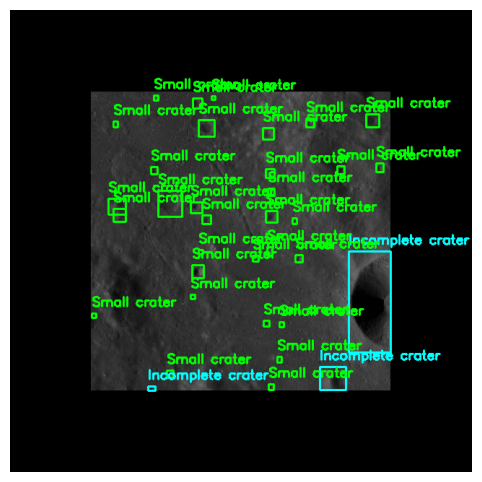

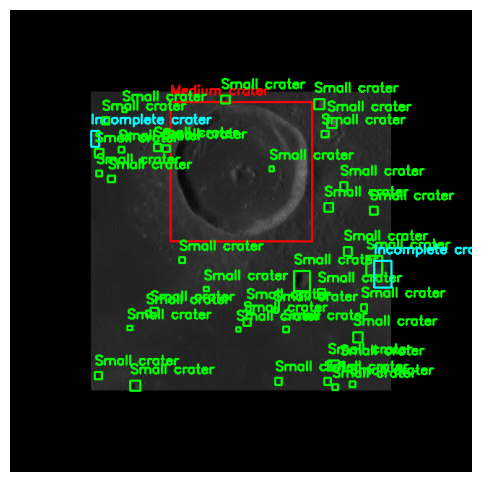

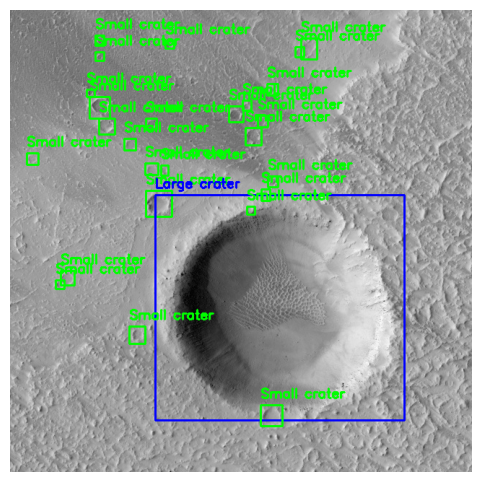

In [41]:
def visualize_annotations(image_path, label_path, class_map, class_colors):
    """
    Draw bounding boxes on images based on YOLO labels.
    """
    image = cv2.imread(image_path)
    h, w, _ = image.shape

    if not os.path.exists(label_path):
        print(f"⚠️ No label found for {image_path}")
        return
    
    with open(label_path, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split()
            class_id = int(parts[0])
            x_center, y_center, box_w, box_h = map(float, parts[1:])
            
            x1 = int((x_center - box_w / 2) * w)
            y1 = int((y_center - box_h / 2) * h)
            x2 = int((x_center + box_w / 2) * w)
            y2 = int((y_center + box_h / 2) * h)

            label = class_map.get(class_id, f"Class {class_id}")
            color = class_colors.get(class_id, (255, 255, 255))  # Default to white if missing

            cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
            cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

# Define dataset path
dataset_path = "final_datasets"
subset = "train"  # Change to 'test' or 'val' to visualize other sets

# Get paths
image_folder = os.path.join(dataset_path, "image", subset)
label_folder = os.path.join(dataset_path, "label", subset)

# Load class names
class_map = load_class_names(label_folder)

# Assign distinct colors to each class
class_colors = {
    0: (255, 0, 0),   # Large crater - Red
    1: (0, 255, 0),   # Small crater - Green
    2: (0, 0, 255),   # Medium crater - Blue
    3: (255, 255, 0)  # Incomplete crater - Yellow
}

# Get a list of image files (limit to first 3)
image_files = [f for f in os.listdir(image_folder) if f.endswith(".jpg")][:3]

if not image_files:
    print("⚠️ No images found in the dataset!")
else:
    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)
        label_path = os.path.join(label_folder, image_file.replace(".jpg", ".txt"))
        visualize_annotations(image_path, label_path, class_map, class_colors)


In [47]:
import pandas as pd
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly"

class_name_map = {
    0: "Large Crater",
    1: "Small Crater",
    2: "Medium Crater",
    3: "Incomplete Crater"
}

color_map = {
    "Large Crater": "orange",
    "Small Crater": "blue",
    "Medium Crater": "red",
    "Incomplete Crater": "green"
}

class_order = ["Large Crater", "Small Crater", "Medium Crater", "Incomplete Crater"]

def get_bounding_box_data(label_folder):

    data = []

    for label_file in os.listdir(label_folder):
        if label_file.endswith(".txt") and label_file != "classes.txt":
            with open(os.path.join(label_folder, label_file), "r", encoding="utf-8") as f:
                for line in f:
                    parts = line.strip().split()
                    class_id = int(parts[0])
                    box_w, box_h = map(float, parts[3:5])
                    area = box_w * box_h
                    data.append({"class": class_name_map[class_id], "area": area})

    return pd.DataFrame(data)

dataset_path = "final_datasets"
train_labels_df = get_bounding_box_data(os.path.join(dataset_path, "label", "train"))
val_labels_df = get_bounding_box_data(os.path.join(dataset_path, "label", "val"))

def plot_bounding_box_distribution(labels_df, title):

    if labels_df.empty:
        print(f"No bounding box data available for {title}")
        return

    fig = px.histogram(
        labels_df, 
        x='area', 
        nbins=50, 
        title=title, 
        color='class',
        category_orders={"class": class_order},
        color_discrete_map=color_map
    )
    fig.show()

plot_bounding_box_distribution(train_labels_df, "Train Bounding Box Area Distribution")
plot_bounding_box_distribution(val_labels_df, "Validation Bounding Box Area Distribution")


In [49]:
# def filter_small_craters(labels_df,classes):
#     if classes == 0:
#         return labels_df[labels_df["class"] == "Large Crater"]
#     if classes == 1:
#         return labels_df[labels_df["class"] == "Small Crater"]
#     if classes == 2:
#         return labels_df[labels_df["class"] == "Medium Crater"]
#     if classes == 3:
#         return labels_df[labels_df["class"] == "Incomplete Crater"]
# 
# def plot_crater_distribution(labels_df, title, classes):
#     small_craters_df = filter_small_craters(labels_df, classes)
# 
#     if small_craters_df.empty:
#         print(f"No bounding box data available for {title}")
#         return
# 
#     fig = px.histogram(
#         small_craters_df, 
#         x='area', 
#         nbins=50, 
#         title=title, 
#         color='class',
#         color_discrete_map=color_map
#     )
#     fig.show()
# 
# plot_crater_distribution(train_labels_df, "Train Large Crater Area Distribution",0)
# plot_crater_distribution(val_labels_df, "Validation Large Crater Area Distribution",0)
# 
# plot_crater_distribution(train_labels_df, "Train Small Crater Area Distribution",1)
# plot_crater_distribution(val_labels_df, "Validation Small Crater Area Distribution",1)
# 
# plot_crater_distribution(train_labels_df, "Train Medium Crater Area Distribution",2)
# plot_crater_distribution(val_labels_df, "Validation Medium Crater Area Distribution",2)
# 
# plot_crater_distribution(train_labels_df, "Train Incomplete Crater Area Distribution",3)
# plot_crater_distribution(val_labels_df, "Validation Incomplete Crater Area Distribution",3)

### Downsampling small craters

In [52]:
import random

dataset_path = "final_datasets"
train_subset = "train"
small_crater_class = "1"
output_folder = "final_datasets_balanced"


os.makedirs(output_folder, exist_ok=True)
os.makedirs(os.path.join(output_folder, "label", train_subset), exist_ok=True)

def balance_small_craters(label_folder, output_label_folder):

    label_files = [f for f in os.listdir(label_folder) if f.endswith(".txt") and f != "classes.txt"]

    for file in label_files:
        file_path = os.path.join(label_folder, file)
        output_file_path = os.path.join(output_label_folder, file)

        with open(file_path, "r", encoding="utf-8") as f:
            lines = f.readlines()

        small_crater_lines = [line for line in lines if line.startswith(small_crater_class)]
        other_crater_lines = [line for line in lines if not line.startswith(small_crater_class)]

        num_other_craters = len(other_crater_lines)
        
        if num_other_craters == 0:
            num_other_craters = 1

        target_small_craters = min(len(small_crater_lines), int(num_other_craters * 1.5))

        if len(small_crater_lines) > target_small_craters:

            small_crater_lines = random.sample(small_crater_lines, target_small_craters)

        new_lines = other_crater_lines + small_crater_lines
        with open(output_file_path, "w", encoding="utf-8") as f:
            f.writelines(new_lines)

train_label_folder = os.path.join(dataset_path, "label", train_subset)
output_label_folder = os.path.join(output_folder, "label", train_subset)

balance_small_craters(train_label_folder, output_label_folder)

print("Downsampling small craters finished!!")


Downsampling small craters finished


In [57]:
balanced_dataset_path = "final_datasets_balanced"

train_image_folder = os.path.join(balanced_dataset_path, "image", "train")
train_label_folder = os.path.join(balanced_dataset_path, "label", "train")

def augment_image(image_path):
    img = cv2.imread(image_path)

    angle = random.choice([0, 90, 180, 270])
    if angle > 0:
        img = cv2.rotate(img, {90: cv2.ROTATE_90_CLOCKWISE, 
                                180: cv2.ROTATE_180, 
                                270: cv2.ROTATE_90_COUNTERCLOCKWISE}[angle])

    if random.choice([True, False]):
        img = cv2.flip(img, 1)
    if random.choice([True, False]):
        img = cv2.flip(img, 0)
    return img


def oversample_large_craters(image_folder, label_folder, target_count):
    image_files = [f for f in os.listdir(image_folder) if f.endswith(".jpg")]
    label_files = [f.replace(".jpg", ".txt") for f in image_files]

    large_crater_images = []
    large_crater_labels = []

    for label_file in label_files:
        label_path = os.path.join(label_folder, label_file)
        with open(label_path, "r", encoding="utf-8") as f:
            for line in f:
                if line.startswith("0"):
                    large_crater_images.append(label_file.replace(".txt", ".jpg"))
                    large_crater_labels.append(label_file)
                    break
    count = len(large_crater_images)

    while count < target_count:
        idx = random.randint(0, len(large_crater_images) - 1)
        image_file = large_crater_images[idx]
        label_file = large_crater_labels[idx]

        img_path = os.path.join(image_folder, image_file)
        new_img = augment_image(img_path)

        new_filename = f"{image_file.split('.')[0]}_aug{count}.jpg"
        new_labelname = f"{label_file.split('.')[0]}_aug{count}.txt"

        cv2.imwrite(os.path.join(image_folder, new_filename), new_img)

        with open(os.path.join(label_folder, label_file), "r", encoding="utf-8") as f:
            label_data = f.readlines()

        with open(os.path.join(label_folder, new_labelname), "w", encoding="utf-8") as f:
            for line in label_data:
                f.write(line)

        count += 1

    print(f"The Large craters have been successfully upsampled to {count}")

target_large_count = 128
oversample_large_craters(train_image_folder, train_label_folder, target_large_count)


The Large craters have been successfully upsampled to 128


In [58]:
dataset = "train"
base_path = "final_datasets_balanced/label"

label_folder = os.path.join(base_path, dataset)
class_map = load_class_names(label_folder)
counts = count_labels(label_folder)

print(f"\n New {dataset.upper()} dataset:")
    
for class_id in sorted(class_map.keys()):
    class_name = class_map.get(class_id, f"class {class_id}")
    count = counts.get(class_id, 0)
    print(f"{class_name} (class {class_id}): {count}")



 New TRAIN dataset:
Large crater (class 0): 128
Small crater (class 1): 476
Medium crater (class 2): 152
Incomplete crater (class 3): 152


In [61]:
# Load a pretrained YOLO model (recommended for training)
model = YOLO("yolov8n.pt")
result = model.train(
    data = 'craters_test.yaml',
    epochs = 200,
    imgsz = 640,
    device = [0,],
    batch = 16,
    workers = 0,
    cache = True
)

print('finished training')


Ultralytics 8.3.85  Python-3.12.3 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=craters_test.yaml, epochs=200, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=True, device=[0], workers=0, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=Tr

train: Scanning D:\study\Project5025\final_datasets_balanced\labels\train... 215 images, 0 backgrounds, 0 corrupt: 100%|██████████| 215/215 [00:00<00:00, 2117.93it/s]

train: New cache created: D:\study\Project5025\final_datasets_balanced\labels\train.cache


WARNING  cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (0.2GB RAM): 100%|██████████| 215/215 [00:00<00:00, 2427.17it/s]
val: Scanning D:\study\Project5025\final_datasets_balanced\labels\val... 20 images, 0 backgrounds, 0 corrupt: 100%|██████████| 20/20 [00:00<00:00, 1735.77it/s]

val: New cache created: D:\study\Project5025\final_datasets_balanced\labels\val.cache
WARNING  cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



val: Caching images (0.0GB RAM): 100%|██████████| 20/20 [00:00<00:00, 1818.27it/s]


Plotting labels to runs\detect\train3\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train3
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      2.21G      1.531      3.621      1.658         45        640: 100%|██████████| 14/14 [00:03<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.15it/s]

                   all         20        404      0.015      0.533      0.138     0.0897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      2.18G      1.386      2.913      1.568         56        640: 100%|██████████| 14/14 [00:03<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.62it/s]

                   all         20        404     0.0182      0.526        0.2       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      2.25G       1.29      2.401       1.41         46        640: 100%|██████████| 14/14 [00:03<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.18it/s]

                   all         20        404      0.662     0.0788       0.19      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      2.19G       1.29      2.238      1.446         24        640: 100%|██████████| 14/14 [00:03<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.27it/s]

                   all         20        404      0.703      0.132      0.319      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      2.19G      1.249      2.084      1.388         66        640: 100%|██████████| 14/14 [00:03<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.58it/s]

                   all         20        404      0.657      0.125       0.27      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      2.25G      1.241      1.953      1.355         28        640: 100%|██████████| 14/14 [00:04<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]

                   all         20        404      0.453      0.239      0.275      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      2.17G      1.284       1.97      1.393         40        640: 100%|██████████| 14/14 [00:04<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]

                   all         20        404      0.351      0.414      0.197      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      2.21G      1.282      1.855      1.426         29        640: 100%|██████████| 14/14 [00:05<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]

                   all         20        404      0.548       0.47      0.338      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      2.19G      1.327      1.914      1.366         89        640: 100%|██████████| 14/14 [00:02<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.68it/s]

                   all         20        404      0.548      0.335      0.339      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      2.22G      1.236      1.804      1.321         93        640: 100%|██████████| 14/14 [00:03<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.57it/s]

                   all         20        404      0.572      0.394      0.432      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      2.17G      1.304      1.867      1.381         51        640: 100%|██████████| 14/14 [00:03<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.70it/s]

                   all         20        404      0.473      0.449      0.422      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      2.17G       1.21      1.683      1.341         63        640: 100%|██████████| 14/14 [00:03<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.67it/s]

                   all         20        404      0.483      0.496      0.447      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      2.17G       1.21      1.662      1.306         56        640: 100%|██████████| 14/14 [00:03<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.70it/s]

                   all         20        404       0.56      0.486      0.426      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      2.17G       1.24      1.671      1.323         40        640: 100%|██████████| 14/14 [00:03<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.72it/s]

                   all         20        404      0.238      0.472      0.245      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      2.19G      1.168      1.605      1.308         29        640: 100%|██████████| 14/14 [00:03<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.20it/s]

                   all         20        404      0.581       0.48      0.545      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      2.17G      1.215      1.666      1.313         54        640: 100%|██████████| 14/14 [00:02<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.10it/s]

                   all         20        404      0.621       0.64      0.618      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      2.21G       1.24      1.671      1.346         41        640: 100%|██████████| 14/14 [00:02<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.97it/s]

                   all         20        404      0.786      0.399       0.59       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      2.22G      1.149        1.5      1.277         46        640: 100%|██████████| 14/14 [00:03<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.80it/s]

                   all         20        404      0.835      0.565      0.659      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      2.23G       1.16      1.596      1.299         22        640: 100%|██████████| 14/14 [00:03<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.33it/s]

                   all         20        404      0.406      0.631      0.557      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      2.16G      1.117      1.444      1.253         39        640: 100%|██████████| 14/14 [00:03<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.26it/s]

                   all         20        404      0.364      0.598      0.527      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      2.19G      1.183      1.487        1.3         33        640: 100%|██████████| 14/14 [00:03<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.25it/s]

                   all         20        404       0.69      0.548       0.58      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      2.17G      1.089      1.392      1.245         35        640: 100%|██████████| 14/14 [00:03<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.49it/s]

                   all         20        404      0.689      0.456      0.603      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      2.16G      1.126      1.448       1.28         76        640: 100%|██████████| 14/14 [00:02<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.43it/s]

                   all         20        404      0.507      0.643      0.582      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      2.16G      1.079      1.357      1.236         32        640: 100%|██████████| 14/14 [00:03<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.60it/s]

                   all         20        404      0.611      0.645      0.632      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      2.16G      1.093       1.39      1.234         49        640: 100%|██████████| 14/14 [00:02<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.41it/s]

                   all         20        404      0.678      0.543      0.601      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      2.19G      1.028      1.309      1.204         50        640: 100%|██████████| 14/14 [00:02<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.22it/s]

                   all         20        404      0.476      0.576      0.511      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      2.17G      1.064      1.328      1.212         33        640: 100%|██████████| 14/14 [00:03<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.22it/s]

                   all         20        404      0.475      0.512      0.491      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200      2.19G      1.055      1.261      1.216         45        640: 100%|██████████| 14/14 [00:03<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.42it/s]

                   all         20        404      0.444      0.578      0.527      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      2.26G      1.011      1.231      1.175         52        640: 100%|██████████| 14/14 [00:03<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.66it/s]

                   all         20        404      0.474      0.644      0.592      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      2.14G       1.03      1.231      1.202         48        640: 100%|██████████| 14/14 [00:03<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.27it/s]

                   all         20        404      0.579       0.65      0.633      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      2.18G      1.037      1.246      1.203         35        640: 100%|██████████| 14/14 [00:03<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.41it/s]

                   all         20        404      0.503      0.587      0.606      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      2.21G      1.005      1.234      1.172         59        640: 100%|██████████| 14/14 [00:02<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.01it/s]

                   all         20        404      0.534      0.633      0.603      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      2.19G     0.9923      1.174      1.216         39        640: 100%|██████████| 14/14 [00:03<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.36it/s]

                   all         20        404      0.521      0.564      0.569      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200       2.2G     0.9999      1.167      1.184         62        640: 100%|██████████| 14/14 [00:03<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.82it/s]

                   all         20        404      0.708      0.524      0.618      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200       2.2G      0.986      1.115      1.165         42        640: 100%|██████████| 14/14 [00:03<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.33it/s]

                   all         20        404      0.465      0.626      0.582      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      2.18G     0.9719      1.096      1.189         54        640: 100%|██████████| 14/14 [00:03<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.08it/s]

                   all         20        404      0.838      0.479      0.623      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      2.14G     0.9386      1.113      1.162         50        640: 100%|██████████| 14/14 [00:03<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.34it/s]

                   all         20        404      0.635      0.568      0.622      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200      2.24G     0.9478       1.12      1.163         38        640: 100%|██████████| 14/14 [00:02<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.38it/s]

                   all         20        404      0.447      0.679      0.594      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      2.22G      0.994      1.122      1.159         61        640: 100%|██████████| 14/14 [00:02<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.28it/s]

                   all         20        404      0.503      0.684      0.625      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      2.24G     0.9802      1.102      1.158         54        640: 100%|██████████| 14/14 [00:03<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.27it/s]

                   all         20        404      0.443       0.65      0.538      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      2.16G      1.001      1.084      1.165         43        640: 100%|██████████| 14/14 [00:03<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.32it/s]

                   all         20        404      0.496      0.673      0.601      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200       2.2G      0.958      1.114      1.159         46        640: 100%|██████████| 14/14 [00:03<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.22it/s]

                   all         20        404      0.779      0.461      0.684      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200       2.2G     0.9485      1.073      1.144         41        640: 100%|██████████| 14/14 [00:03<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.31it/s]

                   all         20        404      0.549      0.721      0.648      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      2.22G     0.9099      1.038      1.159         30        640: 100%|██████████| 14/14 [00:03<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.36it/s]

                   all         20        404      0.569       0.66       0.64      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      2.17G     0.9231     0.9951      1.145         39        640: 100%|██████████| 14/14 [00:03<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.42it/s]

                   all         20        404      0.597      0.678      0.619      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      2.26G     0.9095      1.043      1.115         44        640: 100%|██████████| 14/14 [00:03<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.21it/s]

                   all         20        404      0.466      0.653      0.614      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      2.14G     0.9147      1.008      1.129         54        640: 100%|██████████| 14/14 [00:02<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.26it/s]

                   all         20        404      0.496      0.662      0.632      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      2.18G     0.9146      0.991      1.118         38        640: 100%|██████████| 14/14 [00:03<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.92it/s]

                   all         20        404      0.766      0.416      0.521       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      2.17G     0.9102      1.041      1.127         48        640: 100%|██████████| 14/14 [00:03<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.49it/s]

                   all         20        404      0.747      0.494      0.568      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200      2.18G     0.8928     0.9436      1.096         44        640: 100%|██████████| 14/14 [00:03<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.38it/s]

                   all         20        404      0.377      0.719      0.553      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      2.18G     0.9313      1.031       1.14         39        640: 100%|██████████| 14/14 [00:02<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.45it/s]

                   all         20        404      0.577      0.604      0.589      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      2.14G     0.8603      0.924      1.102         33        640: 100%|██████████| 14/14 [00:03<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.43it/s]

                   all         20        404      0.532      0.662      0.629      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      2.16G      0.888     0.9532       1.14         32        640: 100%|██████████| 14/14 [00:02<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.53it/s]

                   all         20        404      0.777      0.457      0.603       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200      2.22G     0.8692     0.8974      1.114         29        640: 100%|██████████| 14/14 [00:03<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.38it/s]

                   all         20        404      0.535      0.648      0.588      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      2.17G     0.8929     0.9465      1.098         58        640: 100%|██████████| 14/14 [00:02<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.26it/s]

                   all         20        404       0.57      0.626      0.623      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200      2.21G     0.8619     0.9134      1.099         37        640: 100%|██████████| 14/14 [00:03<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.44it/s]

                   all         20        404      0.623      0.469      0.584      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      2.18G     0.8356     0.8694      1.085         62        640: 100%|██████████| 14/14 [00:03<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.53it/s]

                   all         20        404      0.503      0.657      0.631      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      2.22G     0.8515     0.8891      1.092         57        640: 100%|██████████| 14/14 [00:03<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.31it/s]

                   all         20        404      0.489      0.648      0.613      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200       2.2G     0.8716     0.9461      1.102         46        640: 100%|██████████| 14/14 [00:02<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.49it/s]

                   all         20        404      0.503      0.727      0.648      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      2.16G     0.8442     0.9006      1.111         22        640: 100%|██████████| 14/14 [00:03<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.29it/s]

                   all         20        404      0.559      0.669      0.658      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      2.19G     0.8228     0.8783      1.083         34        640: 100%|██████████| 14/14 [00:03<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.01it/s]

                   all         20        404      0.581      0.654      0.607      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200      2.17G     0.8305     0.8535      1.075         60        640: 100%|██████████| 14/14 [00:03<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.42it/s]

                   all         20        404      0.448      0.678      0.602      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      2.22G     0.8217     0.8832      1.081         38        640: 100%|██████████| 14/14 [00:03<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.53it/s]

                   all         20        404      0.534      0.685       0.67      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      2.19G     0.8037     0.8407      1.063         35        640: 100%|██████████| 14/14 [00:03<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.88it/s]

                   all         20        404      0.537       0.61      0.641      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200      2.21G     0.8177     0.8598      1.066         56        640: 100%|██████████| 14/14 [00:03<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.34it/s]

                   all         20        404      0.582      0.573      0.631      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200      2.22G     0.8093     0.8606      1.069         57        640: 100%|██████████| 14/14 [00:02<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.46it/s]

                   all         20        404      0.526      0.599      0.646      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200      2.17G     0.8047     0.8521      1.075         31        640: 100%|██████████| 14/14 [00:02<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.60it/s]

                   all         20        404      0.589      0.649      0.642      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      2.18G     0.7895     0.8388       1.08         36        640: 100%|██████████| 14/14 [00:02<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.49it/s]

                   all         20        404      0.564       0.69      0.678      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      2.19G      0.807     0.8299      1.066         68        640: 100%|██████████| 14/14 [00:02<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.48it/s]

                   all         20        404      0.539      0.683      0.587      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200      2.17G     0.7777     0.8245      1.077         57        640: 100%|██████████| 14/14 [00:03<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.24it/s]

                   all         20        404      0.484      0.694      0.608      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200      2.17G     0.8452     0.8802      1.078         68        640: 100%|██████████| 14/14 [00:02<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.59it/s]

                   all         20        404       0.53      0.719      0.631      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      2.17G     0.8019     0.8416       1.08         47        640: 100%|██████████| 14/14 [00:02<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.45it/s]

                   all         20        404      0.513      0.697      0.631      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200      2.19G     0.8055     0.8007      1.066         41        640: 100%|██████████| 14/14 [00:02<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.27it/s]

                   all         20        404      0.442      0.653      0.598      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200      2.19G     0.7749     0.7819      1.061         65        640: 100%|██████████| 14/14 [00:02<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.61it/s]

                   all         20        404      0.477      0.691      0.565      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200      2.21G     0.7557     0.7941      1.057         42        640: 100%|██████████| 14/14 [00:02<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.53it/s]

                   all         20        404      0.503      0.712      0.584      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200      2.16G     0.7597     0.8235      1.034         54        640: 100%|██████████| 14/14 [00:03<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.22it/s]

                   all         20        404      0.529      0.585      0.592      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200      2.17G     0.7612     0.7772      1.046         49        640: 100%|██████████| 14/14 [00:03<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.55it/s]

                   all         20        404      0.553       0.58      0.556      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200      2.16G       0.74     0.7491       1.03         81        640: 100%|██████████| 14/14 [00:03<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.35it/s]

                   all         20        404      0.557       0.64      0.608      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200      2.21G     0.7449     0.7538      1.046         50        640: 100%|██████████| 14/14 [00:03<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.53it/s]

                   all         20        404      0.506      0.635       0.62      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200      2.21G     0.7372     0.7396      1.042         48        640: 100%|██████████| 14/14 [00:02<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.38it/s]

                   all         20        404      0.594      0.613      0.653      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200      2.16G     0.7604     0.7629      1.041         62        640: 100%|██████████| 14/14 [00:02<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.56it/s]

                   all         20        404      0.547      0.619      0.609      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200      2.17G     0.7496     0.7661      1.059         22        640: 100%|██████████| 14/14 [00:03<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.09it/s]

                   all         20        404      0.536      0.659      0.609      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200      2.18G     0.7414     0.7313      1.039         43        640: 100%|██████████| 14/14 [00:02<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.71it/s]

                   all         20        404      0.494      0.635      0.588      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200      2.21G     0.7352     0.7145       1.03         37        640: 100%|██████████| 14/14 [00:03<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.53it/s]

                   all         20        404      0.514      0.643      0.567      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200      2.14G     0.7191      0.727      1.045         42        640: 100%|██████████| 14/14 [00:02<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.49it/s]

                   all         20        404      0.545      0.661      0.531      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200      2.22G     0.7279     0.7096       1.02         48        640: 100%|██████████| 14/14 [00:03<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.49it/s]

                   all         20        404      0.596      0.649      0.584      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200      2.21G     0.7232     0.7277      1.027         41        640: 100%|██████████| 14/14 [00:03<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.38it/s]

                   all         20        404      0.665      0.521      0.584      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200      2.18G     0.7471      0.722      1.024         30        640: 100%|██████████| 14/14 [00:03<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.24it/s]

                   all         20        404      0.507      0.602      0.598        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200      2.18G     0.7785     0.7754      1.039         37        640: 100%|██████████| 14/14 [00:02<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.47it/s]

                   all         20        404      0.576      0.634      0.625      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200      2.17G     0.7646      0.732      1.052         53        640: 100%|██████████| 14/14 [00:03<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.35it/s]

                   all         20        404      0.494      0.653      0.617      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200      2.18G     0.7661     0.7412      1.031         31        640: 100%|██████████| 14/14 [00:03<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.60it/s]

                   all         20        404      0.703      0.532      0.664      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200      2.17G      0.753     0.7546      1.042         50        640: 100%|██████████| 14/14 [00:03<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.40it/s]

                   all         20        404      0.695      0.497      0.614      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200      2.19G     0.7353     0.7361      1.035         47        640: 100%|██████████| 14/14 [00:03<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.46it/s]

                   all         20        404      0.559      0.632       0.61      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200       2.2G     0.7162     0.7027       1.02         33        640: 100%|██████████| 14/14 [00:03<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.53it/s]

                   all         20        404      0.532      0.566      0.598       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200      2.19G     0.6906      0.681      1.014         36        640: 100%|██████████| 14/14 [00:02<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.44it/s]

                   all         20        404      0.468      0.603      0.607      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200      2.17G     0.7093     0.6946      1.015         46        640: 100%|██████████| 14/14 [00:02<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.20it/s]

                   all         20        404      0.499      0.667      0.559      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200      2.18G     0.7027     0.6802      1.015         50        640: 100%|██████████| 14/14 [00:03<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.61it/s]

                   all         20        404      0.485      0.639      0.542      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200      2.17G     0.6797     0.6588      1.005         44        640: 100%|██████████| 14/14 [00:03<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.45it/s]

                   all         20        404      0.531      0.577      0.583      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200      2.17G     0.6746     0.6528      1.011         42        640: 100%|██████████| 14/14 [00:02<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.44it/s]

                   all         20        404      0.518      0.685      0.612      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200      2.14G     0.6994     0.6631      1.006         41        640: 100%|██████████| 14/14 [00:03<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.21it/s]

                   all         20        404      0.533      0.683      0.612      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200      2.17G      0.672     0.6498      1.005         40        640: 100%|██████████| 14/14 [00:03<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.54it/s]

                   all         20        404       0.63      0.603      0.641      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200      2.23G     0.7156     0.7082      1.034         27        640: 100%|██████████| 14/14 [00:03<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.51it/s]

                   all         20        404      0.611      0.618      0.611      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200      2.19G     0.6978     0.6476      1.008         58        640: 100%|██████████| 14/14 [00:02<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.58it/s]

                   all         20        404      0.587      0.609       0.61      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200      2.22G      0.673     0.6675     0.9927         51        640: 100%|██████████| 14/14 [00:02<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.20it/s]

                   all         20        404      0.598      0.604      0.615      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200      2.17G     0.6792     0.6789      1.028         25        640: 100%|██████████| 14/14 [00:02<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.39it/s]

                   all         20        404       0.51      0.663      0.612      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200      2.25G      0.691     0.6626      1.002         58        640: 100%|██████████| 14/14 [00:02<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.48it/s]

                   all         20        404      0.503       0.65      0.643      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200      2.14G     0.6616     0.6538      1.008         28        640: 100%|██████████| 14/14 [00:02<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.95it/s]

                   all         20        404      0.559      0.702      0.669      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200      2.21G     0.6596      0.644     0.9966         20        640: 100%|██████████| 14/14 [00:02<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.49it/s]

                   all         20        404      0.521      0.724      0.633      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200      2.18G     0.6677     0.6769      1.005         18        640: 100%|██████████| 14/14 [00:02<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.43it/s]

                   all         20        404      0.527      0.631      0.609      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200      2.17G     0.6469     0.6238     0.9969         35        640: 100%|██████████| 14/14 [00:03<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.54it/s]

                   all         20        404       0.54      0.581      0.558      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200      2.21G     0.6606     0.6302     0.9907         44        640: 100%|██████████| 14/14 [00:02<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.53it/s]

                   all         20        404      0.433      0.641      0.542      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200      2.21G     0.6775     0.6506     0.9976         34        640: 100%|██████████| 14/14 [00:03<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.42it/s]

                   all         20        404      0.476       0.69      0.563        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200      2.18G     0.6348     0.6274     0.9921         46        640: 100%|██████████| 14/14 [00:02<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.67it/s]

                   all         20        404      0.457      0.655      0.586      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200      2.21G     0.6551     0.6235       1.01         39        640: 100%|██████████| 14/14 [00:03<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.26it/s]

                   all         20        404      0.509      0.653      0.617      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200      2.18G     0.6598     0.6378      1.014         38        640: 100%|██████████| 14/14 [00:02<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.64it/s]

                   all         20        404      0.511      0.686      0.583      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200      2.19G      0.647     0.6272      1.003         35        640: 100%|██████████| 14/14 [00:02<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.87it/s]

                   all         20        404      0.484      0.607      0.511      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200      2.17G     0.6732     0.6418      1.019         49        640: 100%|██████████| 14/14 [00:03<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.60it/s]

                   all         20        404      0.454      0.586      0.489      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200      2.17G      0.652     0.6288     0.9757         39        640: 100%|██████████| 14/14 [00:03<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.27it/s]

                   all         20        404      0.444      0.641      0.528      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200      2.17G     0.6534     0.6306     0.9953         27        640: 100%|██████████| 14/14 [00:02<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.57it/s]

                   all         20        404      0.488      0.663      0.574      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200      2.16G     0.6254     0.5979     0.9633         46        640: 100%|██████████| 14/14 [00:03<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.47it/s]

                   all         20        404      0.494      0.605      0.573       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200      2.14G     0.6221     0.5909     0.9738         35        640: 100%|██████████| 14/14 [00:02<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.05it/s]

                   all         20        404      0.549      0.649      0.591       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200      2.17G     0.6451     0.6251     0.9833         31        640: 100%|██████████| 14/14 [00:03<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.52it/s]

                   all         20        404      0.545       0.66      0.592      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200      2.19G     0.6559     0.6378     0.9883         41        640: 100%|██████████| 14/14 [00:03<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.46it/s]

                   all         20        404      0.571      0.714      0.608       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200      2.21G     0.6539     0.6085     0.9705         36        640: 100%|██████████| 14/14 [00:02<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.48it/s]

                   all         20        404      0.613      0.676      0.666      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200      2.19G     0.6342     0.6033     0.9822         40        640: 100%|██████████| 14/14 [00:02<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.52it/s]

                   all         20        404      0.584      0.632      0.662      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200      2.17G     0.6191     0.5839     0.9657         55        640: 100%|██████████| 14/14 [00:03<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.38it/s]

                   all         20        404      0.575      0.632      0.645       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200      2.17G     0.6421     0.6035     0.9798         33        640: 100%|██████████| 14/14 [00:03<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.69it/s]

                   all         20        404      0.504      0.685       0.61      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200      2.19G     0.6224     0.5884     0.9893         26        640: 100%|██████████| 14/14 [00:02<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.99it/s]

                   all         20        404      0.488      0.641      0.582      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200      2.24G     0.6394      0.607      0.991         42        640: 100%|██████████| 14/14 [00:03<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.43it/s]

                   all         20        404       0.58      0.571      0.594      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200      2.18G     0.6266     0.5912     0.9788         33        640: 100%|██████████| 14/14 [00:02<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.34it/s]

                   all         20        404      0.594      0.607      0.603      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200      2.17G     0.6493     0.6067     0.9984         29        640: 100%|██████████| 14/14 [00:03<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.77it/s]

                   all         20        404      0.577      0.609      0.592      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200      2.17G     0.6243       0.58     0.9766         67        640: 100%|██████████| 14/14 [00:03<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.79it/s]

                   all         20        404      0.599      0.642      0.604      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/200      2.17G     0.6088     0.5626      0.968         54        640: 100%|██████████| 14/14 [00:02<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.43it/s]

                   all         20        404      0.552      0.653      0.605      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200      2.21G     0.6058     0.5677     0.9567         41        640: 100%|██████████| 14/14 [00:03<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.54it/s]

                   all         20        404      0.544      0.634      0.603      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/200      2.19G     0.6298     0.5587     0.9934         35        640: 100%|██████████| 14/14 [00:03<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.60it/s]

                   all         20        404      0.541      0.639      0.616      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/200      2.19G     0.6074     0.5698     0.9549         46        640: 100%|██████████| 14/14 [00:03<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.49it/s]

                   all         20        404       0.54      0.635      0.608      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/200      2.17G     0.5986     0.5672     0.9584         42        640: 100%|██████████| 14/14 [00:02<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.12it/s]

                   all         20        404      0.526      0.584      0.547      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/200      2.17G     0.6001       0.58     0.9587         42        640: 100%|██████████| 14/14 [00:03<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.59it/s]

                   all         20        404      0.477      0.671       0.55      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/200      2.21G     0.5839     0.5565     0.9751         44        640: 100%|██████████| 14/14 [00:02<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.44it/s]

                   all         20        404      0.553      0.599      0.592      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/200      2.21G     0.6095     0.5663     0.9818         28        640: 100%|██████████| 14/14 [00:03<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.14it/s]

                   all         20        404      0.557      0.622      0.581      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/200      2.21G     0.5707     0.5275     0.9529         57        640: 100%|██████████| 14/14 [00:02<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.52it/s]

                   all         20        404      0.484      0.689      0.609      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/200      2.18G     0.5612     0.5272     0.9571         38        640: 100%|██████████| 14/14 [00:03<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.02it/s]

                   all         20        404      0.498      0.653      0.604      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/200      2.16G     0.5897      0.535     0.9605         53        640: 100%|██████████| 14/14 [00:03<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.51it/s]

                   all         20        404      0.577      0.628      0.629      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/200      2.22G     0.5997      0.552     0.9815         34        640: 100%|██████████| 14/14 [00:03<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.32it/s]

                   all         20        404      0.556      0.627      0.615      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/200       2.2G     0.5801     0.5404     0.9516         26        640: 100%|██████████| 14/14 [00:03<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.75it/s]

                   all         20        404      0.468      0.595      0.551      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/200      2.17G     0.6023     0.5574     0.9762         35        640: 100%|██████████| 14/14 [00:03<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.46it/s]

                   all         20        404      0.481      0.658      0.577      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/200      2.17G     0.5465     0.5231     0.9616         28        640: 100%|██████████| 14/14 [00:03<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.59it/s]

                   all         20        404      0.669      0.527      0.601      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/200      2.27G     0.6087     0.5542      0.957         88        640: 100%|██████████| 14/14 [00:03<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.45it/s]

                   all         20        404      0.507      0.636      0.569      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/200      2.18G     0.5865     0.5607      0.968         46        640: 100%|██████████| 14/14 [00:02<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.65it/s]

                   all         20        404       0.52      0.629      0.571      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/200      2.19G     0.5718      0.539      0.946         40        640: 100%|██████████| 14/14 [00:02<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.38it/s]

                   all         20        404      0.502      0.549      0.549      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/200      2.23G     0.5686     0.5291     0.9665         26        640: 100%|██████████| 14/14 [00:02<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.02it/s]

                   all         20        404      0.472      0.547      0.579       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/200      2.21G     0.5618       0.53     0.9606         44        640: 100%|██████████| 14/14 [00:03<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.01it/s]

                   all         20        404      0.464      0.656      0.605      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/200      2.19G     0.5974     0.5522     0.9609         40        640: 100%|██████████| 14/14 [00:02<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.60it/s]

                   all         20        404      0.497      0.666      0.608      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/200      2.17G     0.5815     0.5421     0.9619         53        640: 100%|██████████| 14/14 [00:03<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.55it/s]

                   all         20        404      0.495      0.694      0.603      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/200      2.26G     0.5906      0.559     0.9638         37        640: 100%|██████████| 14/14 [00:03<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.28it/s]

                   all         20        404      0.522      0.699      0.602      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/200      2.21G     0.5449     0.5396     0.9494         34        640: 100%|██████████| 14/14 [00:03<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.06it/s]

                   all         20        404      0.656      0.567      0.599      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/200      2.23G     0.5656     0.5367     0.9491         46        640: 100%|██████████| 14/14 [00:03<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.56it/s]

                   all         20        404      0.495      0.631      0.574      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/200      2.17G     0.5515       0.53     0.9524         47        640: 100%|██████████| 14/14 [00:02<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.59it/s]

                   all         20        404      0.504      0.633      0.558      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/200      2.16G     0.5718     0.5389     0.9598         41        640: 100%|██████████| 14/14 [00:02<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.04it/s]

                   all         20        404       0.49      0.644      0.563      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/200      2.16G     0.5706     0.5312     0.9515         41        640: 100%|██████████| 14/14 [00:03<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.24it/s]

                   all         20        404      0.531      0.597      0.589      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/200      2.17G     0.5475     0.5135     0.9467         59        640: 100%|██████████| 14/14 [00:03<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.59it/s]

                   all         20        404      0.529      0.584      0.615      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/200      2.17G     0.5559     0.5067     0.9515         42        640: 100%|██████████| 14/14 [00:02<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.37it/s]

                   all         20        404      0.547       0.63      0.611      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/200       2.2G     0.5672     0.5206     0.9449         36        640: 100%|██████████| 14/14 [00:03<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.07it/s]

                   all         20        404      0.526      0.639      0.599      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/200      2.19G     0.5585     0.5108      0.943         53        640: 100%|██████████| 14/14 [00:02<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.57it/s]

                   all         20        404      0.518       0.65       0.57      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/200      2.18G     0.5185     0.4925     0.9295         54        640: 100%|██████████| 14/14 [00:03<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.32it/s]

                   all         20        404      0.526      0.617      0.566       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/200      2.23G     0.5517     0.5148      0.942         26        640: 100%|██████████| 14/14 [00:03<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.47it/s]

                   all         20        404      0.542      0.682       0.57      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/200      2.19G     0.5372     0.5111     0.9572         53        640: 100%|██████████| 14/14 [00:02<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.18it/s]

                   all         20        404      0.521      0.699      0.582      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/200      2.18G     0.5592     0.5113     0.9579         37        640: 100%|██████████| 14/14 [00:03<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.55it/s]

                   all         20        404      0.544       0.62      0.617      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/200       2.2G     0.5696     0.5177     0.9452         58        640: 100%|██████████| 14/14 [00:02<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.20it/s]

                   all         20        404       0.65      0.555      0.619      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/200      2.16G     0.5412     0.4968     0.9399         62        640: 100%|██████████| 14/14 [00:02<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.31it/s]

                   all         20        404      0.528      0.566      0.584      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/200      2.17G     0.5438     0.4923     0.9468         92        640: 100%|██████████| 14/14 [00:02<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.43it/s]

                   all         20        404      0.536      0.616      0.571      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/200      2.17G     0.5514     0.5056     0.9519         37        640: 100%|██████████| 14/14 [00:03<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.53it/s]

                   all         20        404      0.491      0.578      0.547      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/200      2.17G     0.5265     0.4817     0.9355         36        640: 100%|██████████| 14/14 [00:03<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.57it/s]

                   all         20        404      0.467       0.57      0.547      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/200      2.17G     0.5121     0.4729     0.9269         48        640: 100%|██████████| 14/14 [00:03<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.65it/s]

                   all         20        404      0.509      0.566      0.554      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/200      2.14G     0.5311     0.4699     0.9225         46        640: 100%|██████████| 14/14 [00:02<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.55it/s]

                   all         20        404      0.536      0.633       0.59      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/200      2.17G      0.513     0.4785     0.9338         36        640: 100%|██████████| 14/14 [00:03<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.39it/s]

                   all         20        404       0.54      0.631      0.581      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/200      2.19G     0.5356     0.4886     0.9334         31        640: 100%|██████████| 14/14 [00:02<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.66it/s]

                   all         20        404      0.529      0.624      0.572      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/200      2.14G     0.4812     0.4625     0.9268         31        640: 100%|██████████| 14/14 [00:03<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.42it/s]

                   all         20        404      0.538      0.631      0.585      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/200      2.19G     0.5356     0.4798     0.9439         38        640: 100%|██████████| 14/14 [00:02<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.17it/s]

                   all         20        404      0.516      0.634      0.584       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/200      2.21G     0.5061     0.4623     0.9333         66        640: 100%|██████████| 14/14 [00:03<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.87it/s]

                   all         20        404      0.531      0.654      0.602      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/200      2.21G     0.5266     0.5005     0.9408         47        640: 100%|██████████| 14/14 [00:02<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.45it/s]

                   all         20        404       0.54      0.644      0.594      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/200      2.17G     0.5152     0.4736      0.938         29        640: 100%|██████████| 14/14 [00:03<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.59it/s]

                   all         20        404      0.505      0.625      0.585      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/200      2.19G     0.5149     0.4595     0.9393         43        640: 100%|██████████| 14/14 [00:02<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.60it/s]

                   all         20        404      0.497      0.634      0.592      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/200      2.24G     0.5311     0.4674     0.9392         54        640: 100%|██████████| 14/14 [00:03<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.55it/s]

                   all         20        404      0.507      0.639      0.615      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/200      2.17G     0.5338     0.4792     0.9305         58        640: 100%|██████████| 14/14 [00:02<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.51it/s]

                   all         20        404      0.523      0.602      0.617      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/200      2.21G     0.5002     0.4502     0.9277         42        640: 100%|██████████| 14/14 [00:03<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.01it/s]

                   all         20        404      0.606      0.576      0.606      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/200      2.32G     0.4771     0.4437     0.9147         37        640: 100%|██████████| 14/14 [00:02<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.44it/s]

                   all         20        404      0.511      0.635      0.607      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/200      2.21G     0.4901     0.4502     0.9294         48        640: 100%|██████████| 14/14 [00:02<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.53it/s]

                   all         20        404      0.561      0.651      0.594      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/200      2.18G     0.5129     0.4739     0.9297         40        640: 100%|██████████| 14/14 [00:02<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.35it/s]

                   all         20        404      0.531       0.65      0.593      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/200      2.19G     0.4949     0.4443      0.911         28        640: 100%|██████████| 14/14 [00:02<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.37it/s]

                   all         20        404      0.535      0.647      0.603      0.419


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/200      2.14G     0.7014     0.7591      1.009         50        640: 100%|██████████| 14/14 [00:02<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.59it/s]

                   all         20        404      0.555      0.656      0.608      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/200      2.16G     0.6794     0.7927     0.9904         19        640: 100%|██████████| 14/14 [00:02<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.97it/s]

                   all         20        404      0.524      0.649      0.595      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/200      2.16G      0.649     0.6441      0.958         32        640: 100%|██████████| 14/14 [00:02<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.60it/s]

                   all         20        404      0.523      0.623      0.602      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/200      2.17G     0.6687     0.6714     0.9876         27        640: 100%|██████████| 14/14 [00:02<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.48it/s]

                   all         20        404      0.504      0.649      0.594      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/200      2.16G      0.664     0.6421     0.9781         24        640: 100%|██████████| 14/14 [00:02<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.57it/s]

                   all         20        404       0.49      0.652      0.601       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/200      2.14G     0.6559     0.6202     0.9532         34        640: 100%|██████████| 14/14 [00:02<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.16it/s]

                   all         20        404      0.505      0.653      0.607      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/200      2.16G     0.6321     0.6058     0.9403         18        640: 100%|██████████| 14/14 [00:02<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.57it/s]

                   all         20        404      0.647      0.577      0.612      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/200      2.17G     0.6096     0.5793     0.9458         26        640: 100%|██████████| 14/14 [00:02<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.35it/s]

                   all         20        404      0.489      0.651      0.599      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/200      2.16G     0.6182      0.603     0.9528         29        640: 100%|██████████| 14/14 [00:02<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.58it/s]

                   all         20        404      0.492      0.638      0.598      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/200      2.16G     0.6367     0.5896     0.9783         13        640: 100%|██████████| 14/14 [00:02<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.73it/s]

                   all         20        404        0.5      0.643      0.612      0.458



200 epochs completed in 0.195 hours.
Optimizer stripped from runs\detect\train3\weights\last.pt, 6.3MB
Optimizer stripped from runs\detect\train3\weights\best.pt, 6.3MB

Validating runs\detect\train3\weights\best.pt...
Ultralytics 8.3.85  Python-3.12.3 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.66it/s]


                   all         20        404      0.559        0.7       0.67      0.484
          Large crater          6          6      0.706          1      0.898       0.73
          Small crater         17        351      0.765      0.288      0.479       0.23
         Medium crater          9         13      0.334      0.846      0.749      0.613
     Incomplete crater         15         34       0.43      0.667      0.552      0.363
Speed: 0.2ms preprocess, 1.5ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs\detect\train3
finished training


In [6]:
model = YOLO(r"runs\detect\train3\weights\best.pt")

model.val(
    data = 'craters_test.yaml',
    epochs = 200,
    imgsz = 640,
    device = [0,],
    batch = 16,
    workers = 0,
    conf = 0.25,
    iou = 0.6,
    cache = True
)

Ultralytics 8.3.85  Python-3.12.3 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning D:\study\Project5025\final_datasets_balanced\labels\val.cache... 20 images, 0 backgrounds, 0 corrupt: 100%|██████████| 20/20 [00:00<?, ?it/s]

WARNING  cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



val: Caching images (0.0GB RAM): 100%|██████████| 20/20 [00:00<00:00, 1428.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.99it/s]


                   all         20        404      0.784      0.481      0.645      0.508
          Large crater          6          6        0.8      0.667      0.766      0.635
          Small crater         17        351          1     0.0302      0.525      0.354
         Medium crater          9         13      0.675      0.846      0.734      0.617
     Incomplete crater         15         34      0.663      0.382      0.554      0.426
Speed: 4.5ms preprocess, 12.0ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\val2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000020BD8C4FC80>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
       

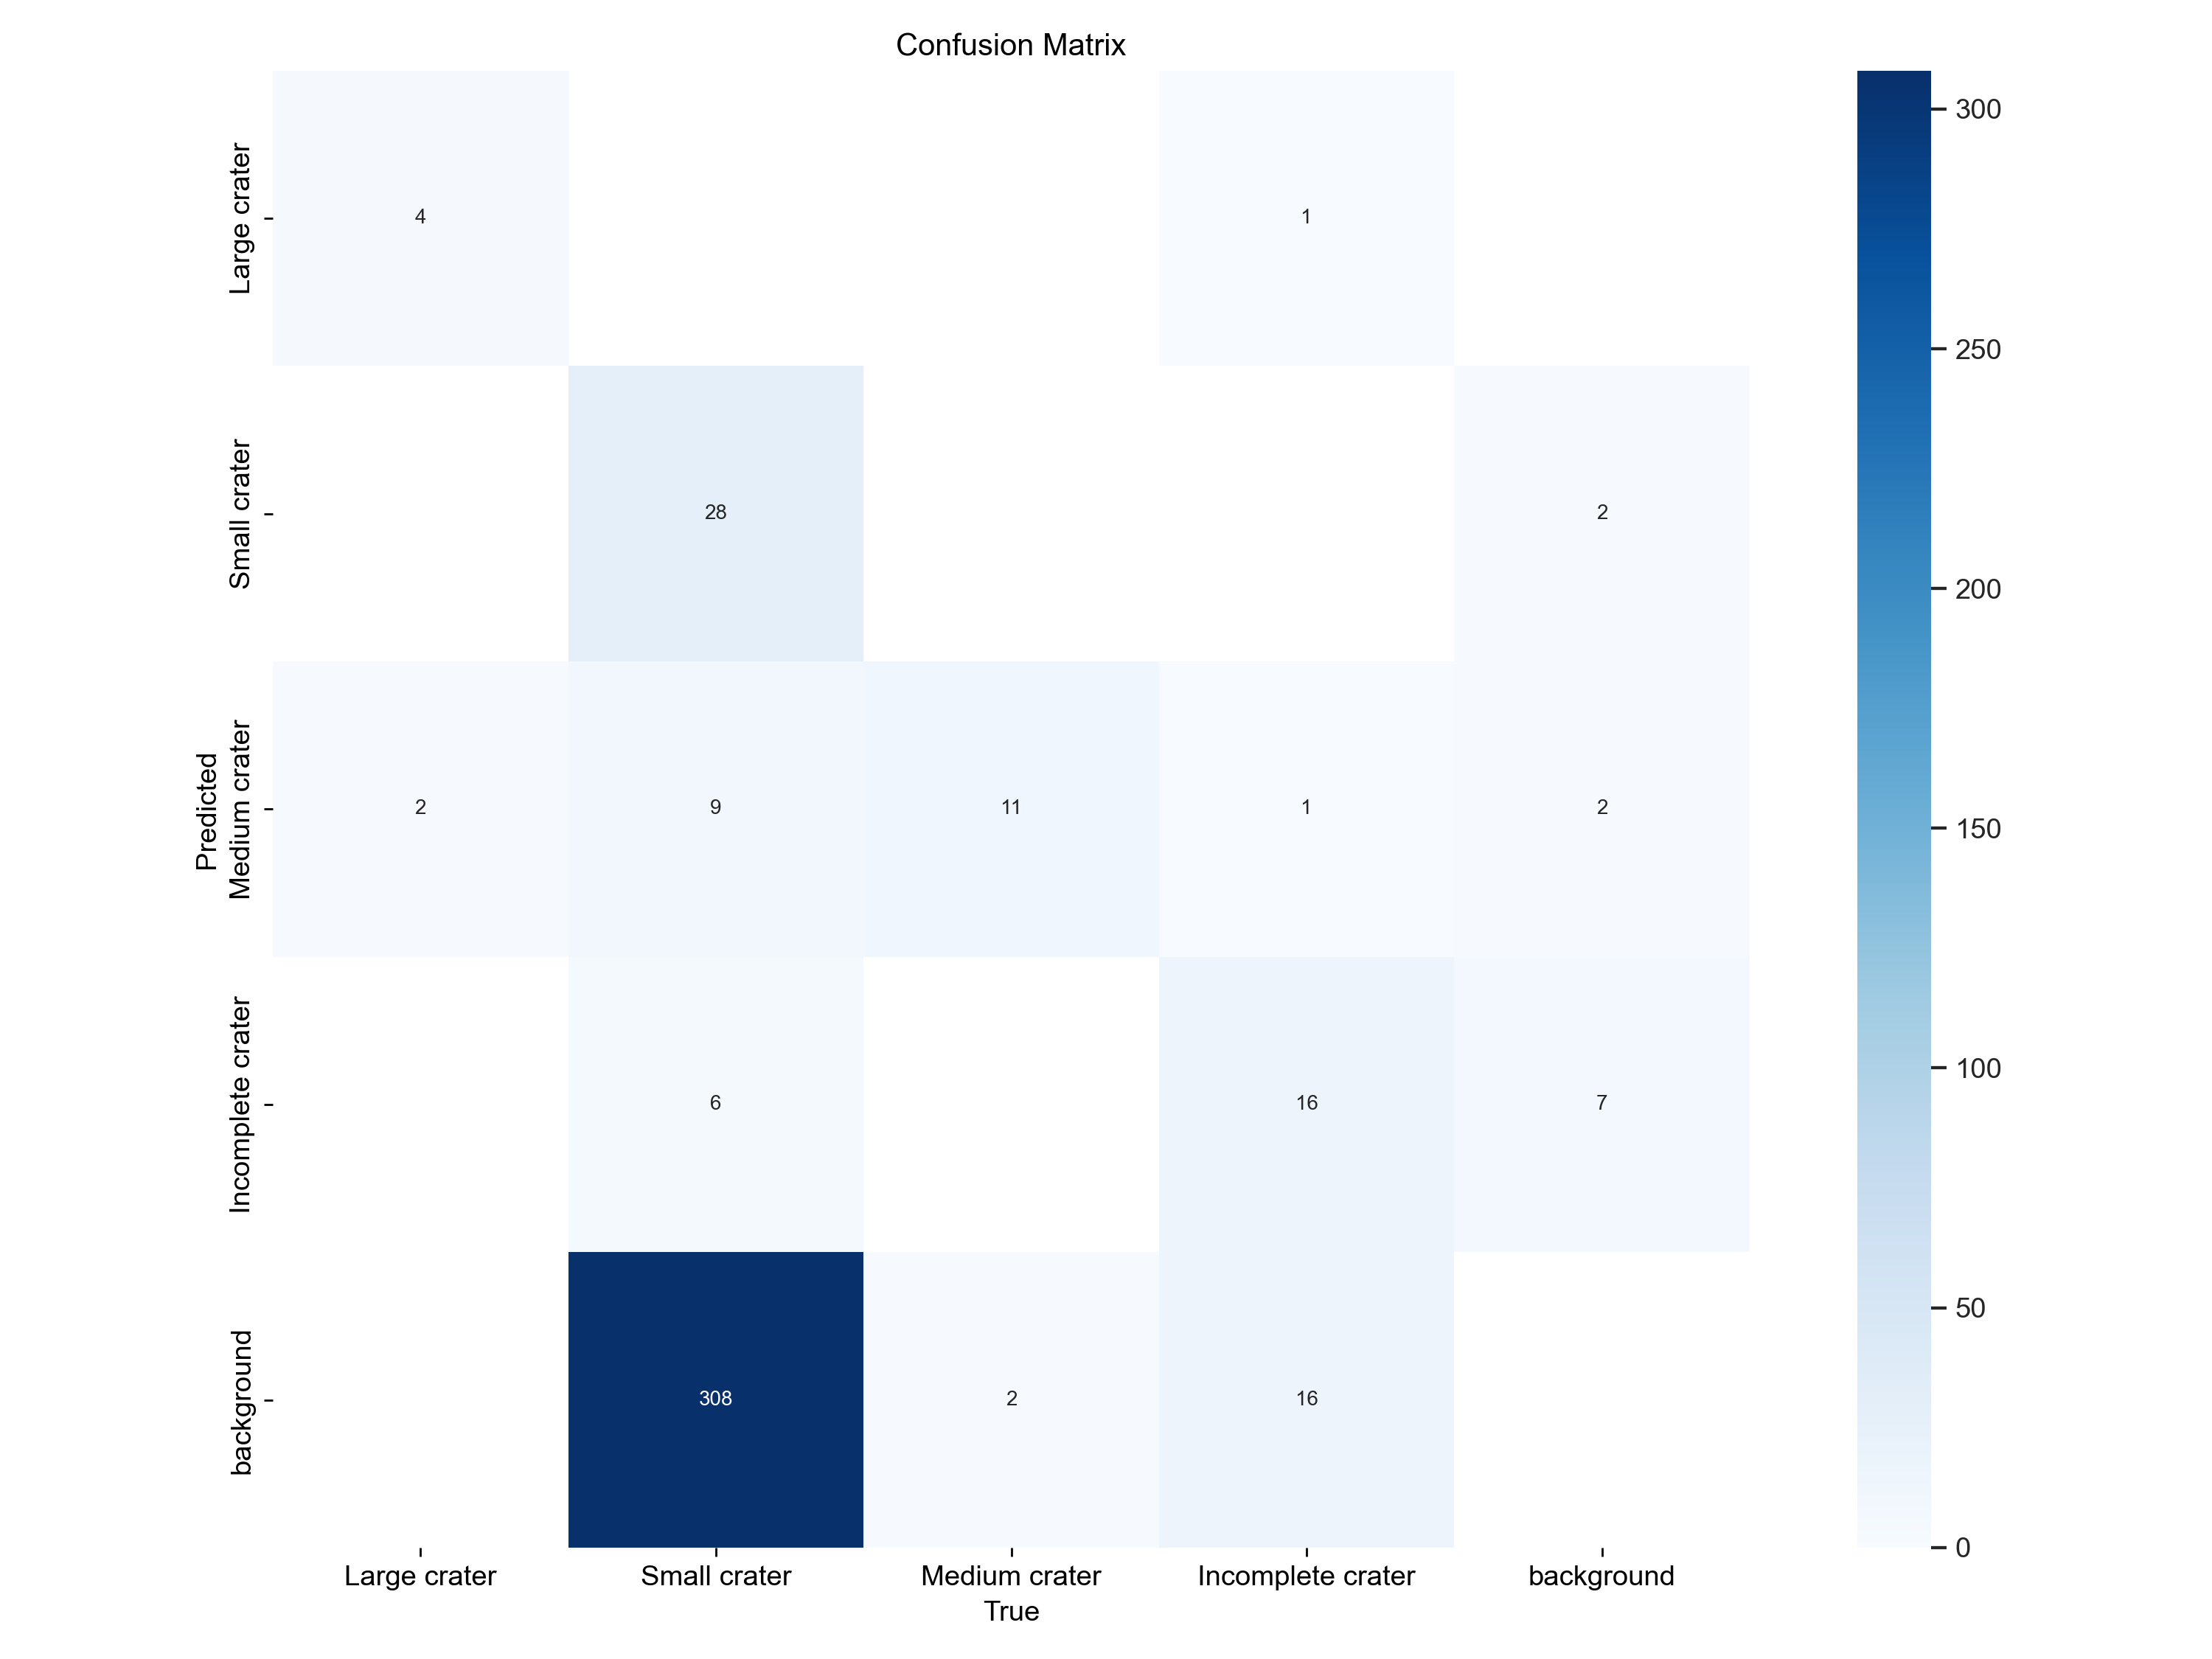

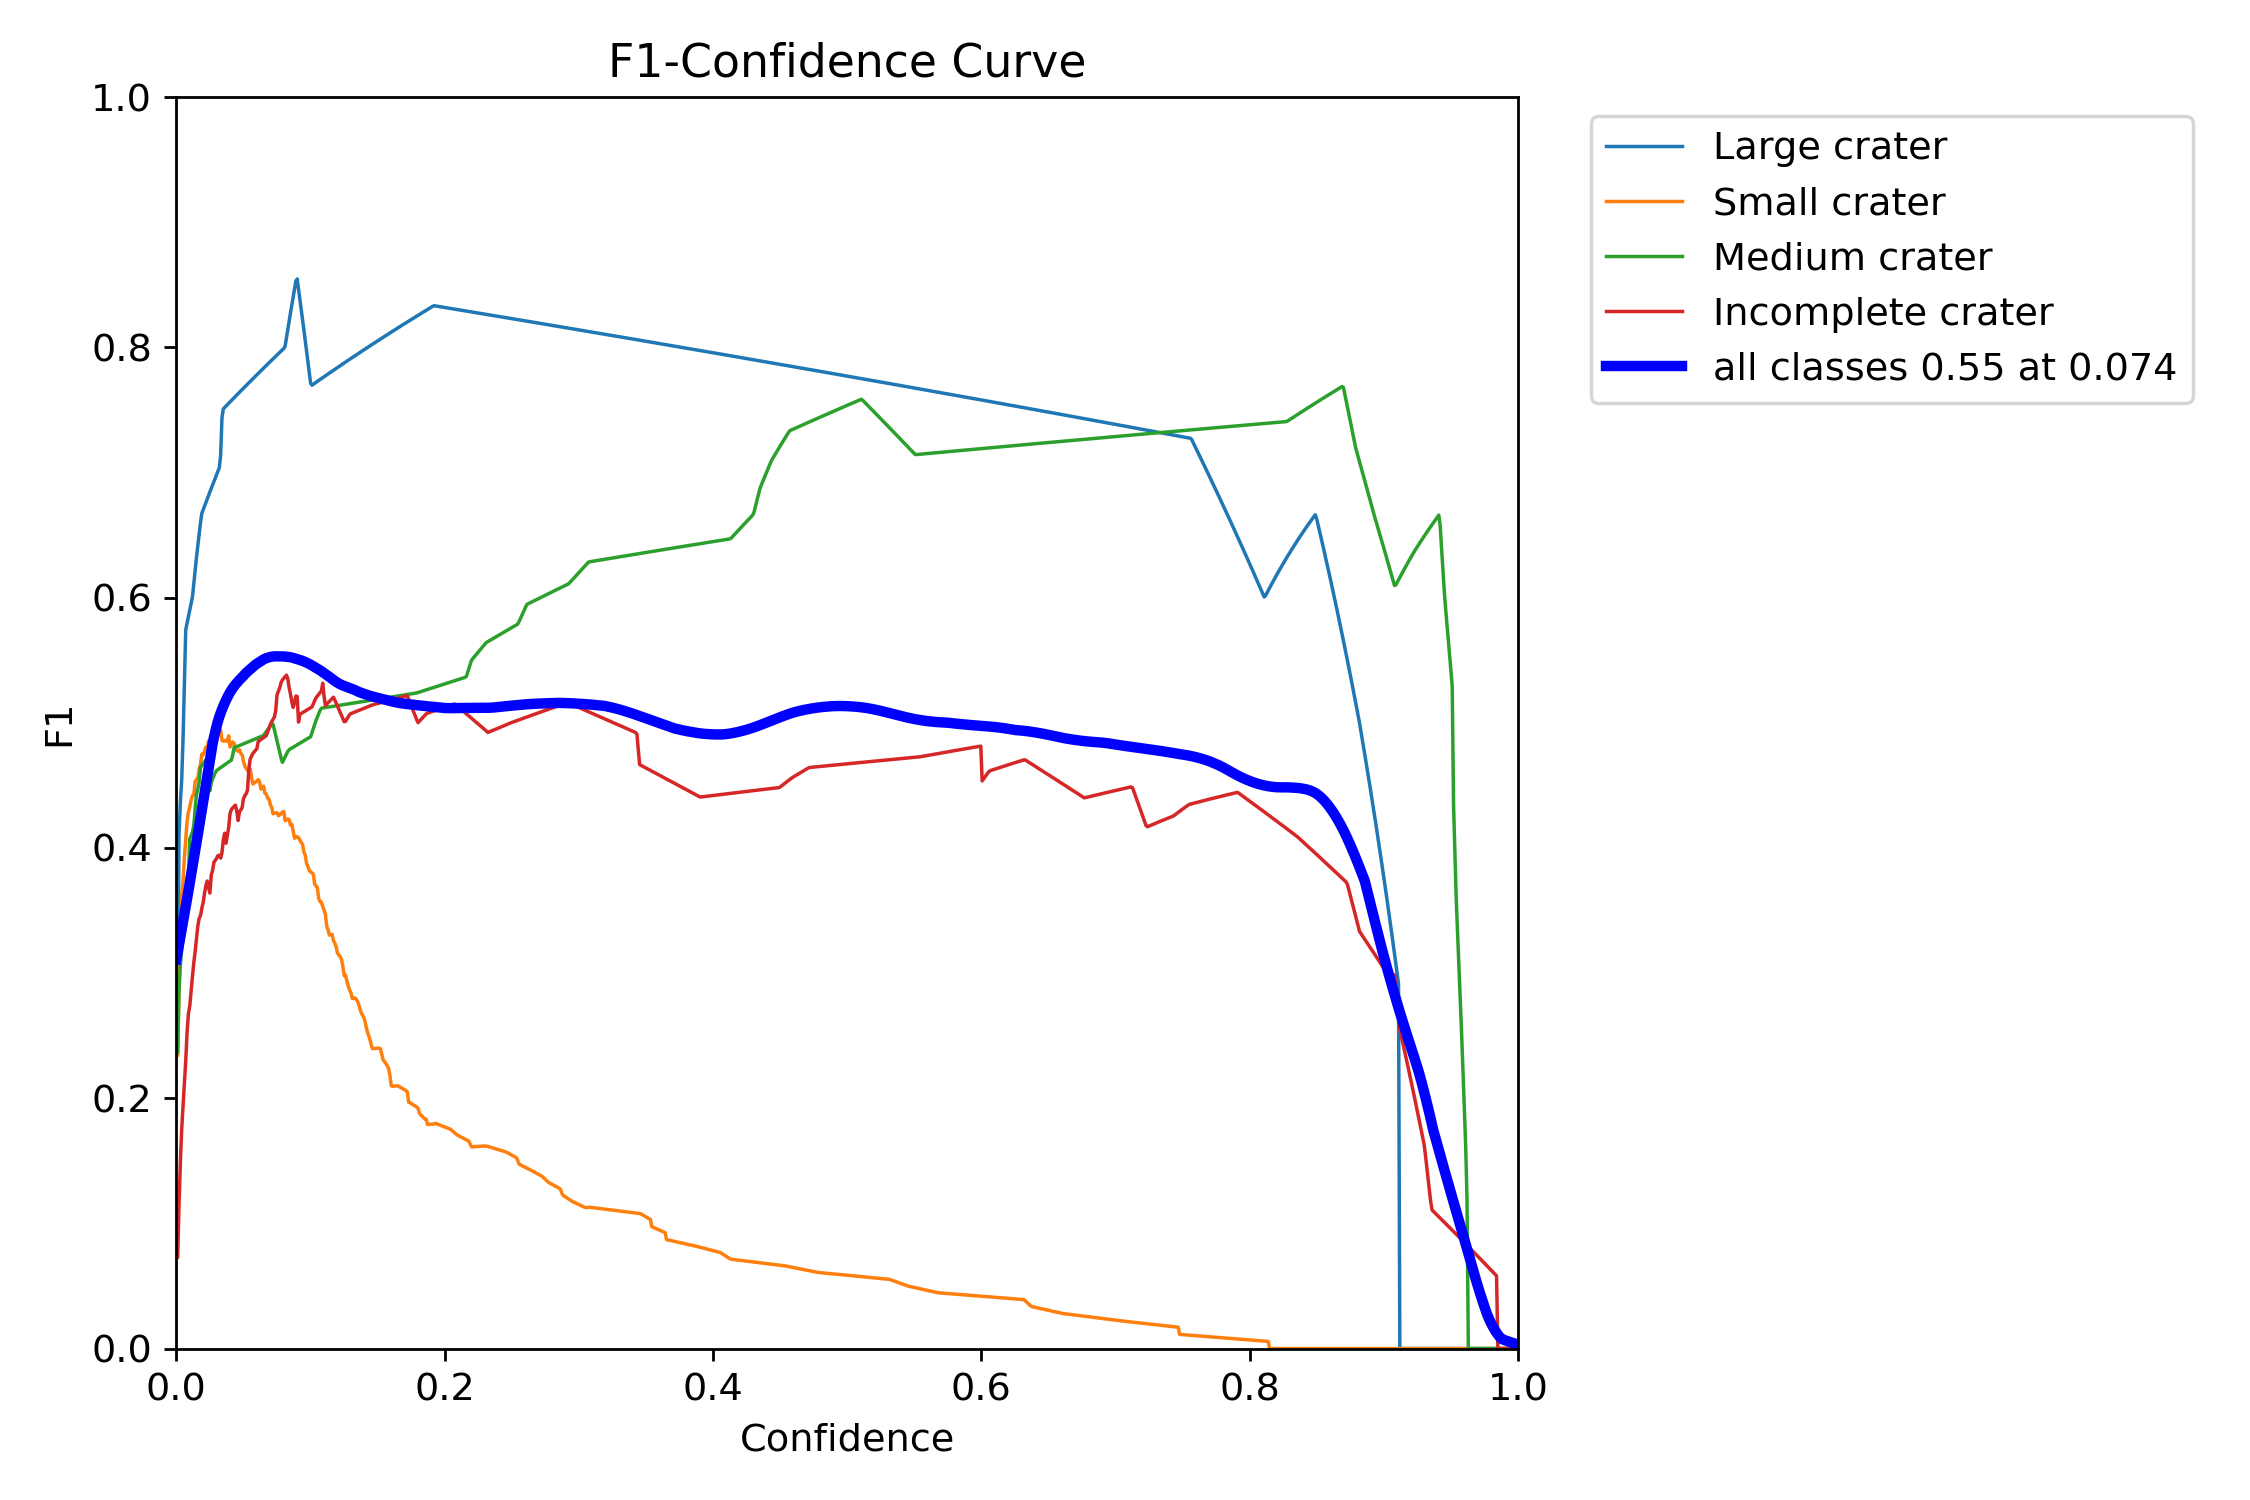

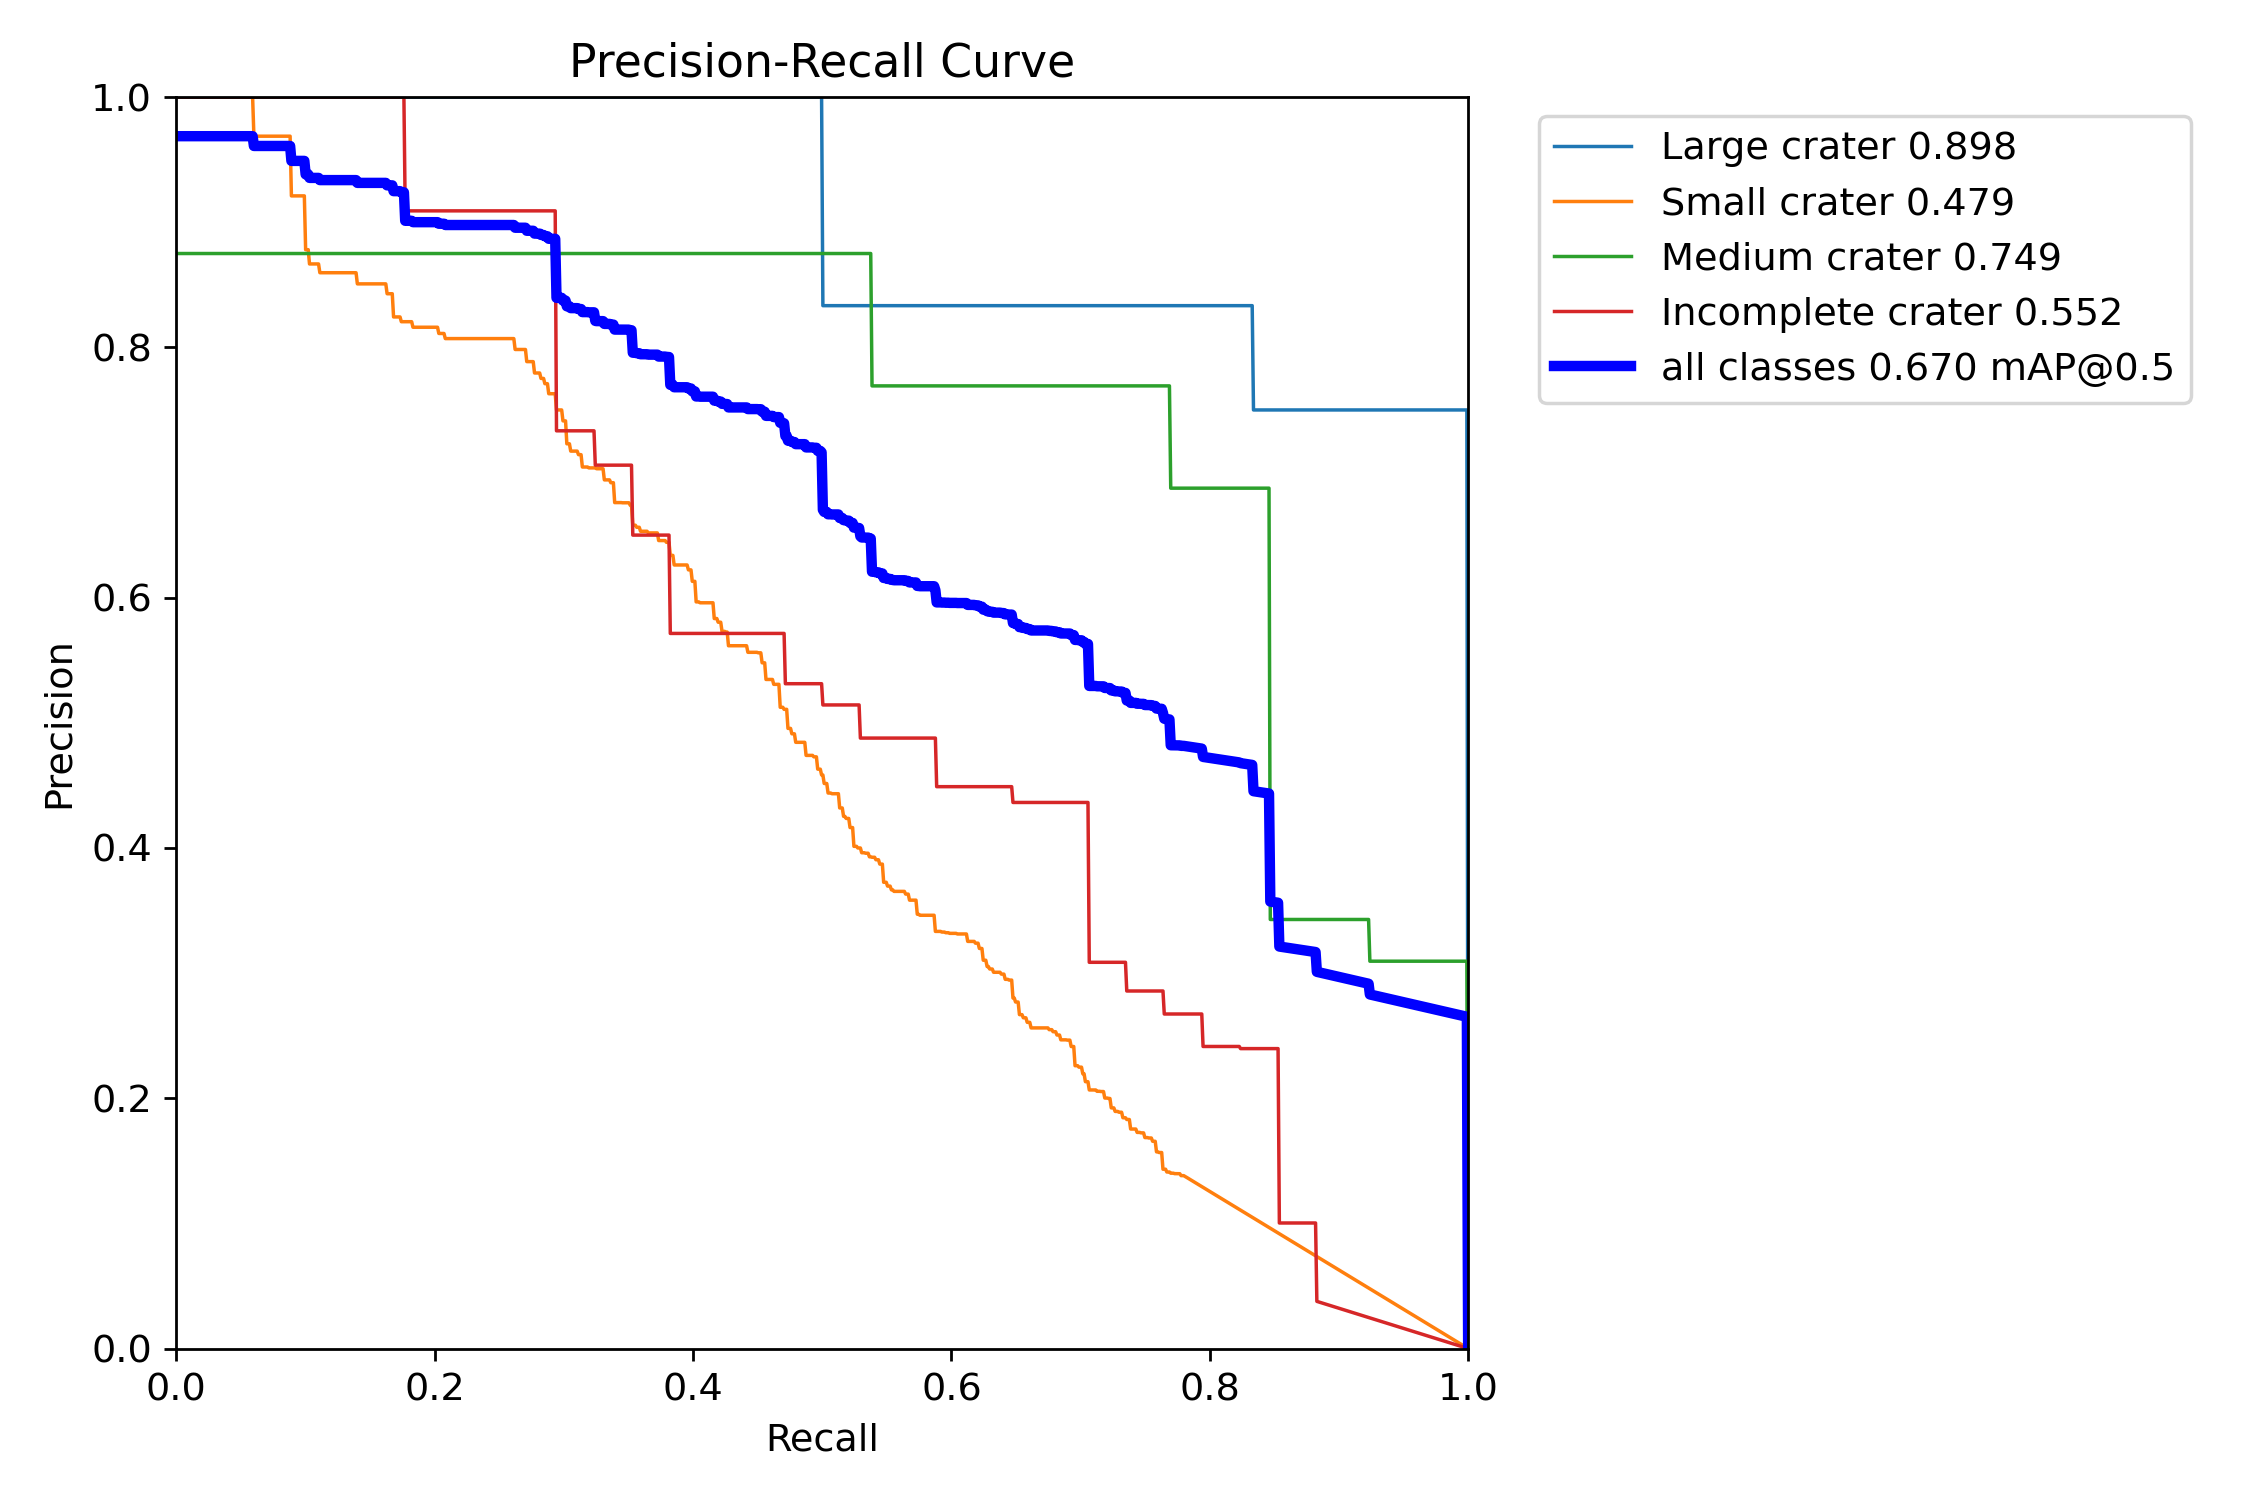

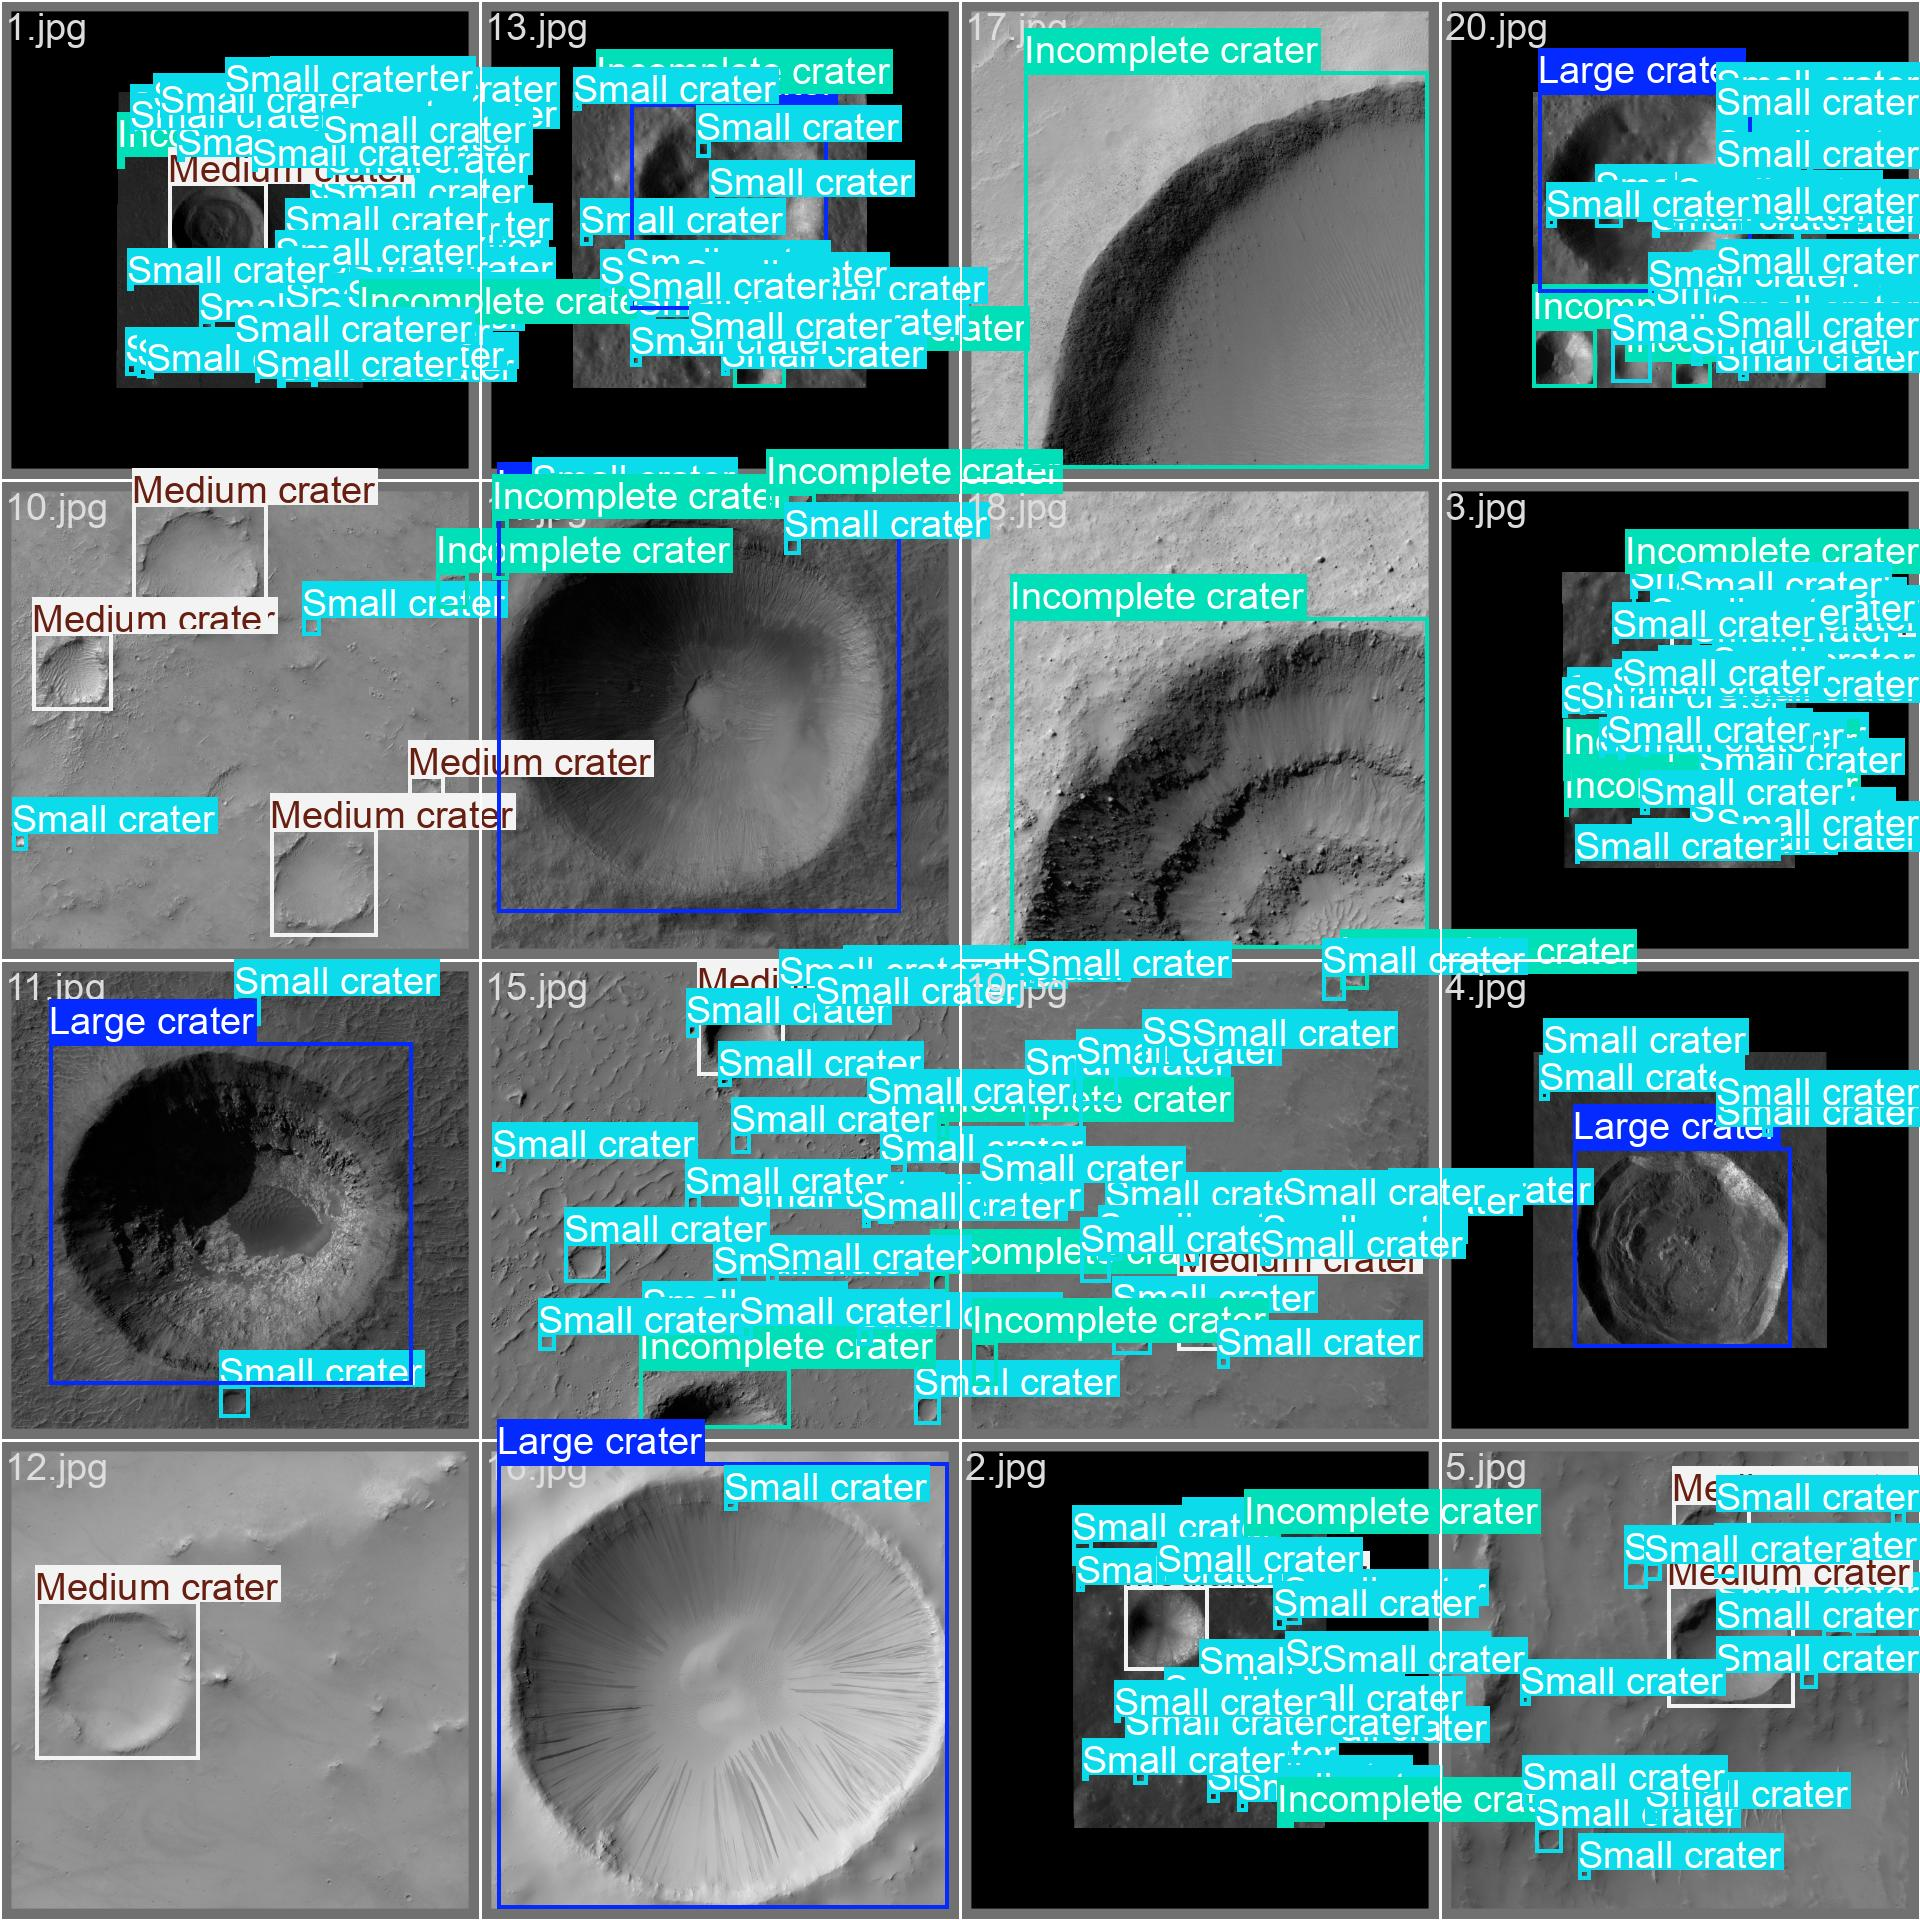

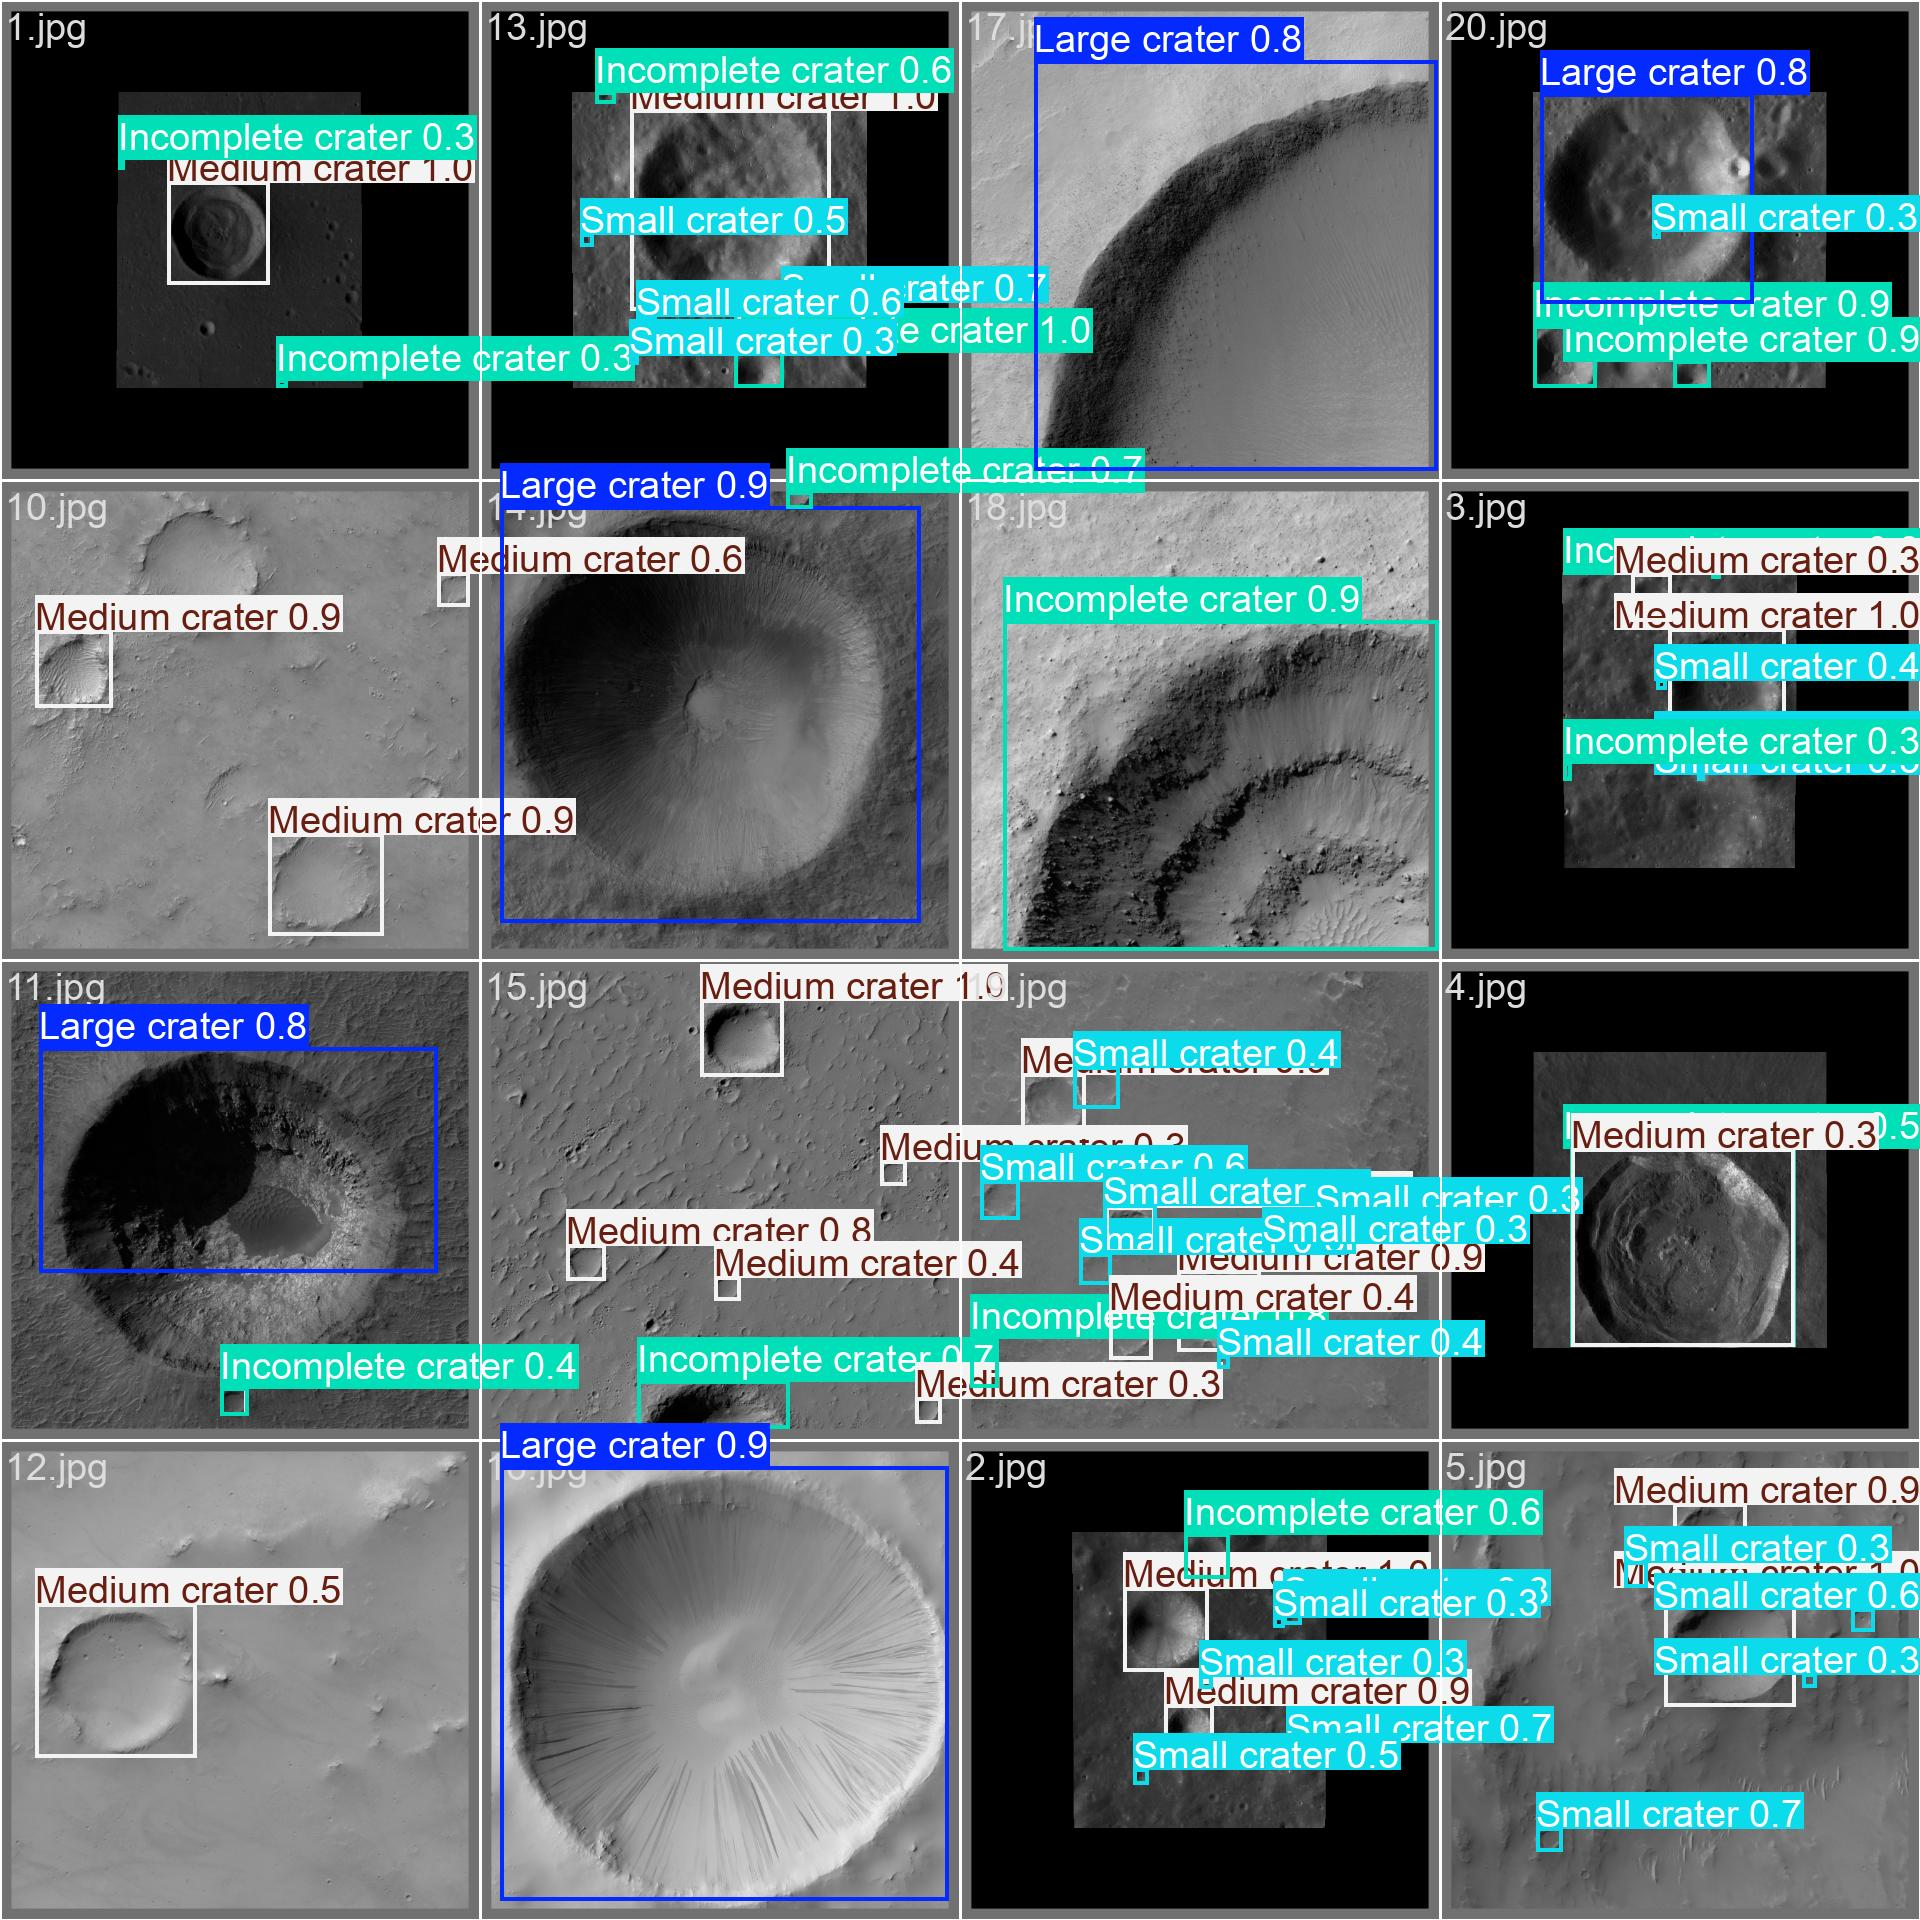

In [13]:
from IPython.display import Image, display
import os

result_dir = "runs/detect/train3"
image_files = {
    "confusion matrix": "confusion_matrix.png",
    "F1 curve": "F1_curve.png",
    "PR curve": "PR_curve.png",
    "val labels": "val_batch0_labels.jpg",
    "val pred": "val_batch0_pred.jpg"
}

# 显示图片
for name, filename in image_files.items():
    img_path = os.path.join(result_dir, filename)
    if os.path.exists(img_path):
        display(Image(filename=img_path, width=600))
    else:
        print(f"not find files: {img_path}")
